# Breast Cancer Prediction

I built 4 models to predict the diagnosis of breast cancer with different methods: decision tree, logistic regression, k-nearest neighbors and support vector machine. I measured the model goodness by accuracy (the percentage of correct predictions within all predictions)

Data: https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/wdbc.data

Description: https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancerwisconsin/wdbc.names

## Data Processing

### Import package

In [3]:
import numpy as np
import pandas as pd
import itertools
import seaborn as sns
import scikitplot as skplt
import matplotlib.pyplot as plt

from sklearn import tree, metrics
from sklearn.svm import SVC
from sklearn.metrics import roc_curve,auc
from sklearn.model_selection import cross_val_score, train_test_split, KFold
from sklearn.metrics import confusion_matrix, make_scorer, accuracy_score, classification_report
from sklearn.model_selection import learning_curve, StratifiedKFold, train_test_split
from sklearn.feature_selection import RFECV, SelectFromModel
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from matplotlib.colors import ListedColormap
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import matthews_corrcoef
from sklearn.tree import export_graphviz
import graphviz

import warnings
warnings.filterwarnings("ignore")

### Load dataset

In [4]:
from sklearn.datasets import load_breast_cancer
wdbc = load_breast_cancer()
df = pd.DataFrame(np.c_[wdbc['target'], wdbc['data']], columns=np.append(['MB'],wdbc['feature_names']))

# diagnosis
df['MB'] = df['MB'].replace('M',1) # M = malignant
df['MB'] = df['MB'].replace('B',0) # B = benign
df

,MB,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,0.0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,0.2419,...,25.380,17.33,184.60,2019.0,0.16220,0.66560,0.7119,0.2654,0.4601,0.11890
1,0.0,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,0.1812,...,24.990,23.41,158.80,1956.0,0.12380,0.18660,0.2416,0.1860,0.2750,0.08902
2,0.0,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,0.2069,...,23.570,25.53,152.50,1709.0,0.14440,0.42450,0.4504,0.2430,0.3613,0.08758
3,0.0,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,0.2597,...,14.910,26.50,98.87,567.7,0.20980,0.86630,0.6869,0.2575,0.6638,0.17300
4,0.0,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,0.1809,...,22.540,16.67,152.20,1575.0,0.13740,0.20500,0.4000,0.1625,0.2364,0.07678
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,0.0,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,0.1726,...,25.450,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115
565,0.0,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,0.1752,...,23.690,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637
566,0.0,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,0.1590,...,18.980,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820
567,0.0,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,0.2397,...,25.740,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087,0.12400


In [5]:
n_samples, n_features = wdbc.data.shape
print ('The dimensions of the data set are', n_samples, 'by', n_features)
print('The classes are: ', wdbc.target_names)
print('The features in the data set are:', wdbc.feature_names)

The dimensions of the data set are 569 by 30
The classes are:  ['malignant' 'benign']
The features in the data set are: ['mean radius' 'mean texture' 'mean perimeter' 'mean area'
 'mean smoothness' 'mean compactness' 'mean concavity'
 'mean concave points' 'mean symmetry' 'mean fractal dimension'
 'radius error' 'texture error' 'perimeter error' 'area error'
 'smoothness error' 'compactness error' 'concavity error'
 'concave points error' 'symmetry error' 'fractal dimension error'
 'worst radius' 'worst texture' 'worst perimeter' 'worst area'
 'worst smoothness' 'worst compactness' 'worst concavity'
 'worst concave points' 'worst symmetry' 'worst fractal dimension']


## Data Exploration

In [6]:
# define dependent and independent variables
x = df.drop('MB', axis = 1)
y = df['MB']

### Correlation matrix

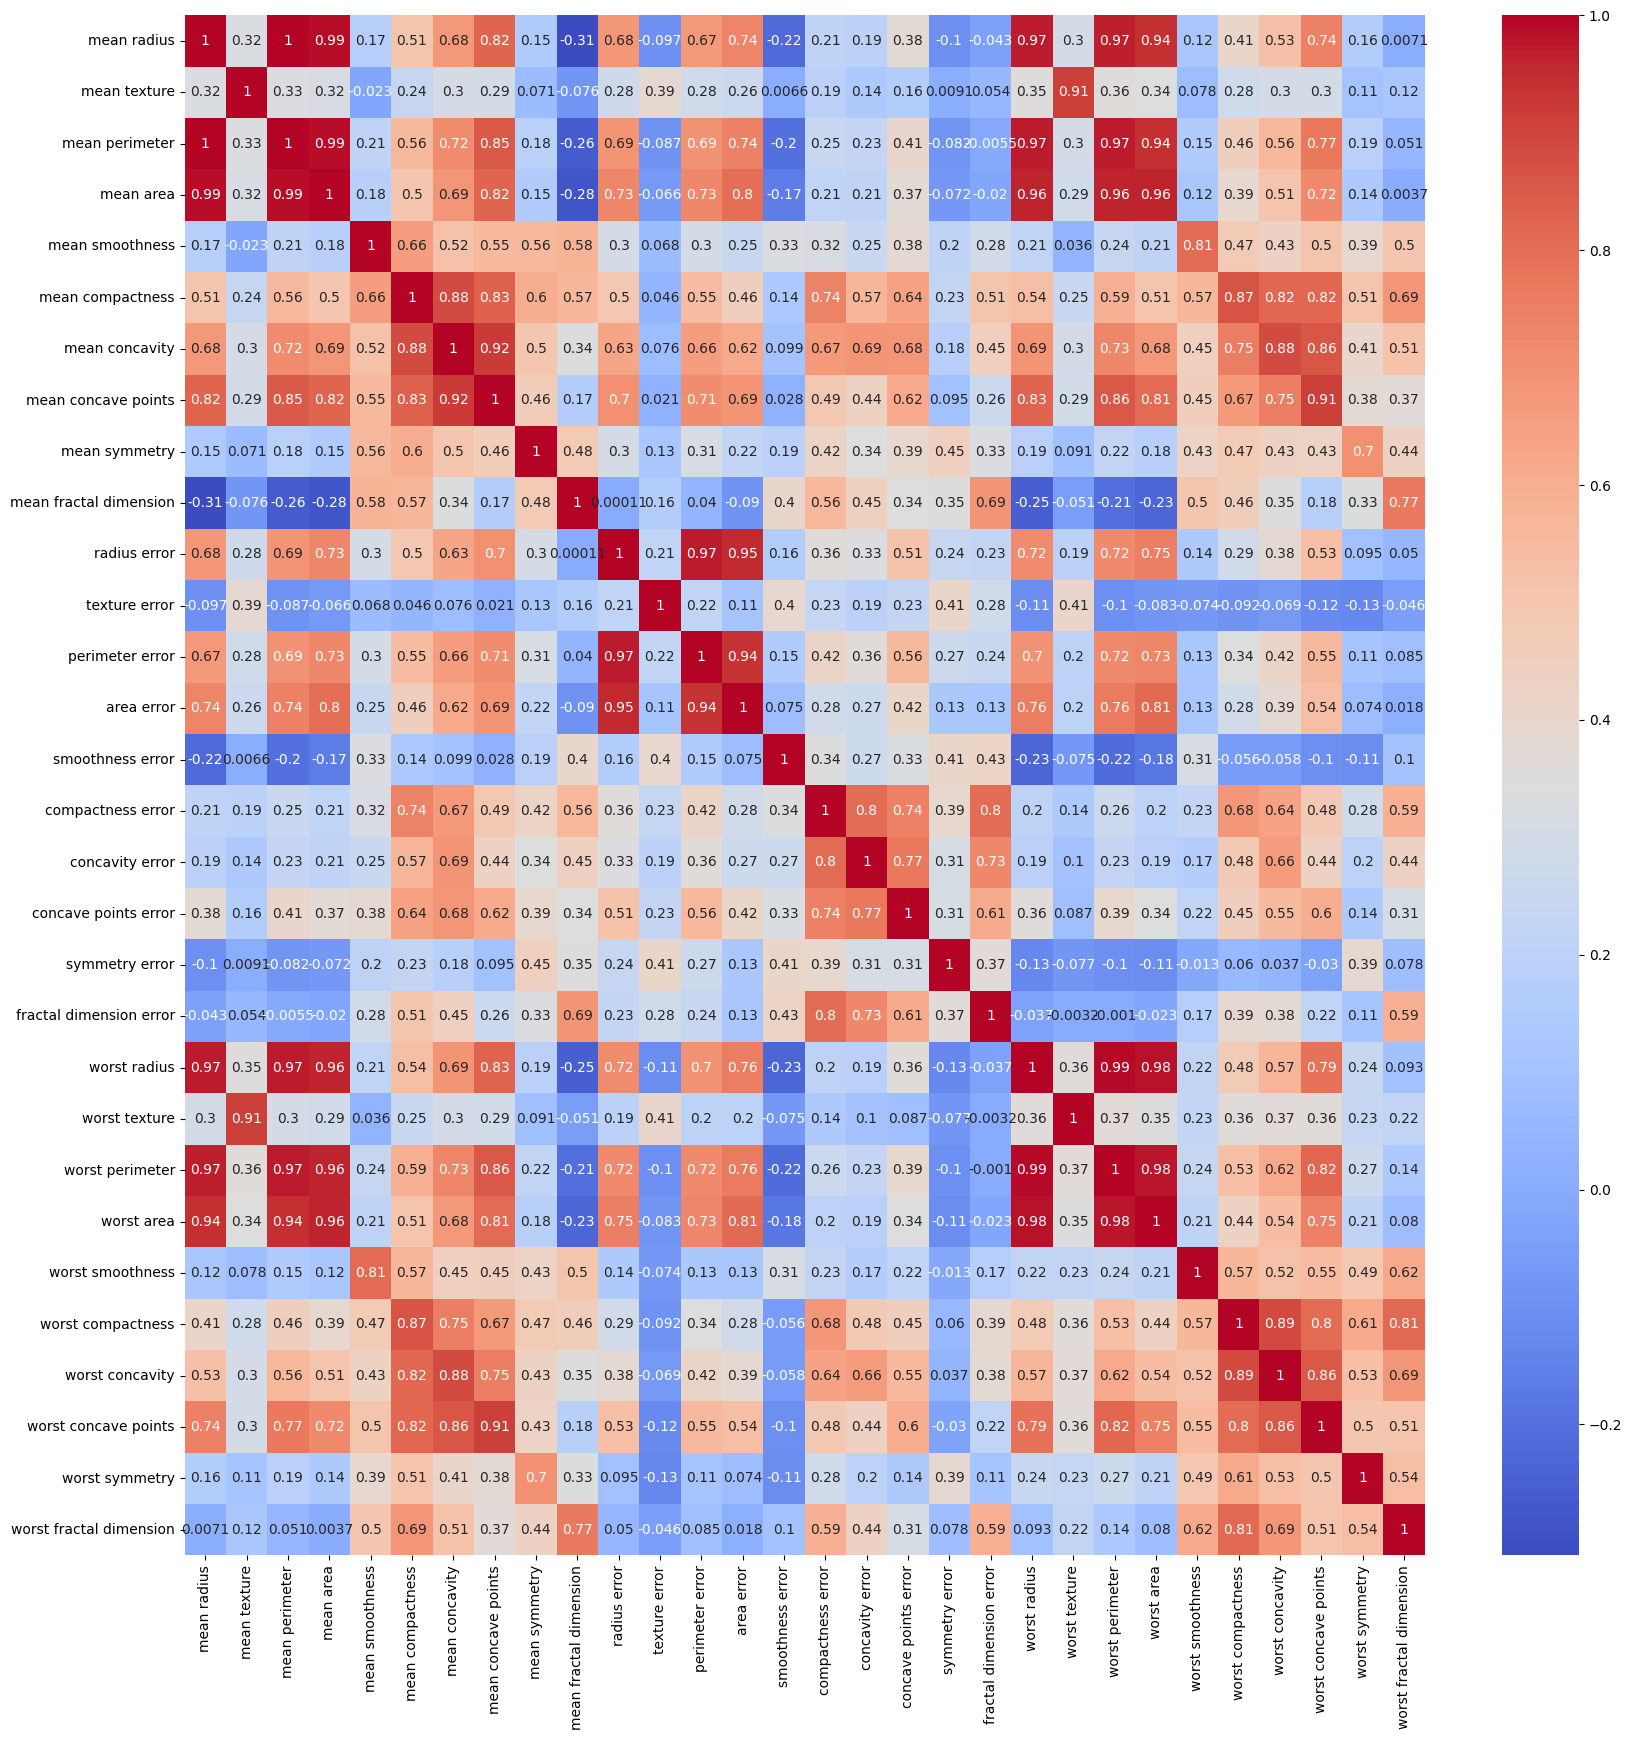

In [7]:
plt.subplots(figsize=(20, 20))
sns.heatmap(x.corr(), annot=True, cmap="coolwarm")
plt.show()

### Top3 Highest-correlated features

In [8]:
corr_matrix = df.corr()
top3_features = abs(corr_matrix['MB']).sort_values(ascending=False)[1:4]
top3_features

worst concave points    0.793566
worst perimeter         0.782914
mean concave points     0.776614
Name: MB, dtype: float64

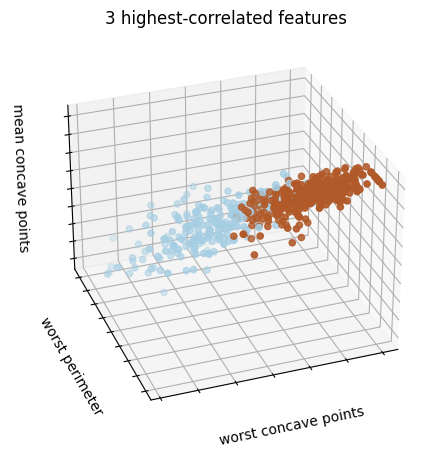

In [10]:
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(1, figsize=(4, 4))
ax = Axes3D(fig, elev=-150, azim=110)

# redefine X and Y
X = df.loc[:, ['worst concave points', 'worst perimeter', 'mean concave points']].values # only top 3
Y = wdbc.target
X_reduced = df.loc[:, ['worst concave points', 'worst perimeter', 'mean concave points']].values

ax.scatter(X_reduced[:, 0], X_reduced[:, 1], X_reduced[:, 2], c=Y, cmap=plt.cm.Paired)
ax.set_title("3 highest-correlated features")
ax.set_xlabel("worst concave points")
ax.w_xaxis.set_ticklabels([])
ax.set_ylabel("worst perimeter")
ax.w_yaxis.set_ticklabels([])
ax.set_zlabel("mean concave points")
ax.w_zaxis.set_ticklabels([])

plt.show()

## Modeling

### Split train-test dataset

In [11]:
X = df.drop('MB', axis = 1)
y = df['MB']

# testing dataset = 0.2
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

### Cross-validation for inner and outer loops

In [12]:
inner_cv=KFold(n_splits=5, shuffle=True, random_state=42)
outer_cv=KFold(n_splits=5, shuffle=True, random_state=42)

## (1) Decision Tree

In [79]:
# Tuning hyperparameters in DecisionTreeClassifier
criterions = ['gini', 'entropy']
d_rng =  list(range(1,10)) # max_depth
s_rng = list(range(2,10)) # min_samples_split
t_grid = dict(max_depth = d_rng, criterion = criterions, min_samples_split=s_rng)

# model
tree = DecisionTreeClassifier()

In [80]:
# non-nested parameter search and scoring
tree_clf = GridSearchCV(estimator=tree, param_grid=t_grid, cv = inner_cv, scoring = 'accuracy')

In [81]:
# fit the models
tree_clf.fit(X_train, y_train)
y_pred = tree_clf.predict(X_test)

In [82]:
# nested CV with parameter opitimization
tree_score=cross_val_score(tree_clf,X=X,y=y, cv=outer_cv)

## Evaluate performance by model goodness
tree_acc_scores = accuracy_score(y_test, y_pred)
conf_mtrx = confusion_matrix(y_test, y_pred)
cfr = classification_report(y_test, y_pred)

In [83]:
print('Best score =',tree_clf.best_score_)
print('Best parameters:' ,tree_clf.best_params_)
print('Best estimator: ', tree_clf.best_estimator_)
print("Mean of cross validation scores: ",tree_score.mean())
print('Predictive accuracy: ', tree_acc_scores)
print('\n')
print('Confusion matrix: \n', conf_mtrx)
print('\n')
print('Classification report:''\n', cfr)

Best score = 0.9428571428571428
Best parameters: {'criterion': 'gini', 'max_depth': 6, 'min_samples_split': 5}
Best estimator:  DecisionTreeClassifier(max_depth=6, min_samples_split=5)
Mean of cross validation scores:  0.9402421984163949
Predictive accuracy:  0.956140350877193


Confusion matrix: 
 [[35  5]
 [ 0 74]]


Classification report:
               precision    recall  f1-score   support

         0.0       1.00      0.88      0.93        40
         1.0       0.94      1.00      0.97        74

    accuracy                           0.96       114
   macro avg       0.97      0.94      0.95       114
weighted avg       0.96      0.96      0.96       114



The AUC is:  0.9375
The kappa stats is:  0.9008695652173913
The MCC stats is:  0.9053288094192943


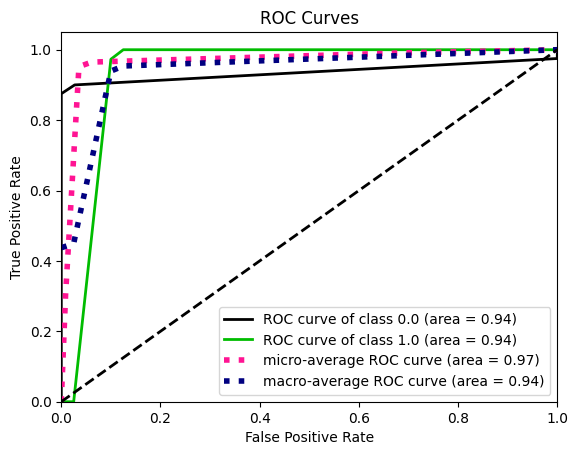

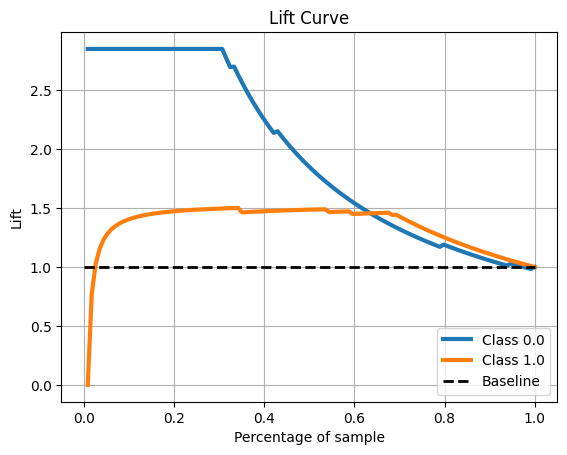

In [84]:
# AUC
fpr, tpr, threshold = roc_curve(y_test, y_pred)
auc = metrics.auc(fpr, tpr)
print("The AUC is: ", auc)
print("The kappa stats is: ", cohen_kappa_score(y_test, y_pred))
print("The MCC stats is: ", matthews_corrcoef(y_test, y_pred))

# ROC curve
predicted_probas_tree = tree_clf.predict_proba(X_test)
skplt.metrics.plot_roc(y_test, predicted_probas_tree)

# Lift curve
skplt.metrics.plot_lift_curve(y_test, predicted_probas_tree)
plt.show()

## (2) KNN

In [85]:
# Normalization
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_train_normalized = scaler.fit_transform(X_train)
X_test_normalized = scaler.transform(X_test)

In [86]:
# Tuning hyperparameters in KNeighborsClassifier
k_rng = list(range(1,10)) # n_neighbors
weight = ['uniform', 'distance'] # weights
grid = dict(n_neighbors = k_rng, weights = weight)

# model
knn = KNeighborsClassifier()

In [87]:
# non-nested parameter search and scoring
knn_clf = GridSearchCV(estimator=knn, param_grid=grid, cv = inner_cv, scoring = 'accuracy')

In [88]:
# fit the models
knn_clf.fit(X_train_normalized, y_train)
y_pred = knn_clf.predict(X_test_normalized)

In [89]:
# nested CV with parameter opitimization
knn_score=cross_val_score(knn_clf,X=X,y=y, cv=outer_cv)

# Evaluate performance by model goodness
knn_acc_scores = accuracy_score(y_test, y_pred)
conf_mtrx = confusion_matrix(y_test, y_pred)
cfr = classification_report(y_test, y_pred)

In [90]:
print('Best score: ', knn_clf.best_score_)
print('Best parameters: ' , knn_clf.best_params_)
print('Best estimator: ', knn_clf.best_estimator_)
print("Mean of cross validation scores: ",knn_score.mean())
print('Predictive accuracy: ', knn_acc_scores)
print('\n')
print('Confusion matrix: \n', conf_mtrx)
print('\n')
print('Classification report:''\n', cfr)
print('\n') 

Best score:  0.9670329670329669
Best parameters:  {'n_neighbors': 5, 'weights': 'uniform'}
Best estimator:  KNeighborsClassifier()
Mean of cross validation scores:  0.9243906225741345
Predictive accuracy:  0.9912280701754386


Confusion matrix: 
 [[39  1]
 [ 0 74]]


Classification report:
               precision    recall  f1-score   support

         0.0       1.00      0.97      0.99        40
         1.0       0.99      1.00      0.99        74

    accuracy                           0.99       114
   macro avg       0.99      0.99      0.99       114
weighted avg       0.99      0.99      0.99       114





The AUC is:  0.9874999999999999
The kappa stats is:  0.9806320081549439
The MCC stats is:  0.9808159868191383


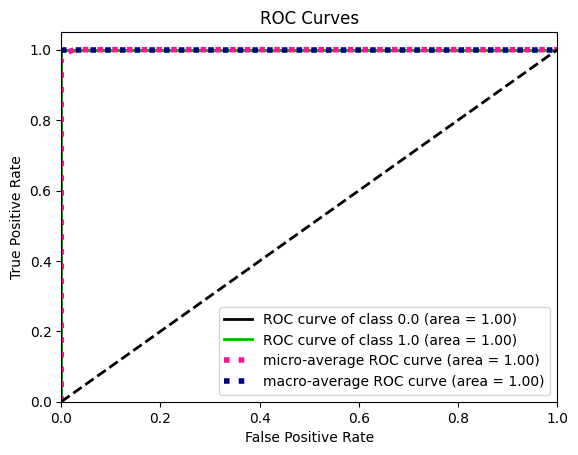

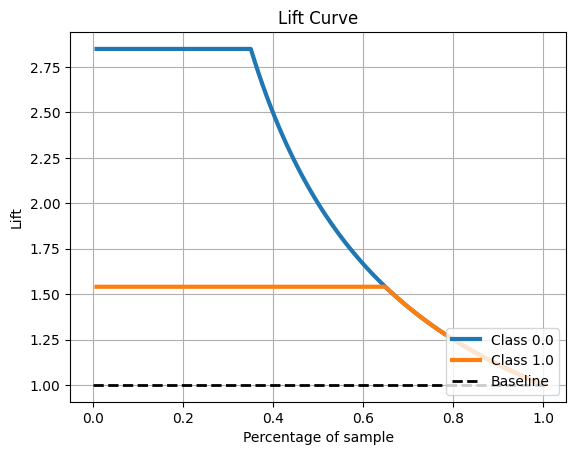

In [91]:
# AUC
fpr, tpr, threshold = roc_curve(y_test, y_pred)
auc = metrics.auc(fpr, tpr)
print("The AUC is: ", auc)
print("The kappa stats is: ", cohen_kappa_score(y_test, y_pred))
print("The MCC stats is: ", matthews_corrcoef(y_test, y_pred))

# ROC curve
predicted_probas_knn = knn_clf.predict_proba(X_test_normalized)
skplt.metrics.plot_roc(y_test, predicted_probas_knn)

# Lift curve
skplt.metrics.plot_lift_curve(y_test, predicted_probas_knn)
plt.show()

## (3) Logistic Regression 

In [92]:
# Tuning hyperparameters in Logistic Regression
c_rng=[10**i for i in range(-5,5)] #C
solve = ["liblinear", "newton-cg"] #solver
penal=['l1', 'l2', 'elasticnet', 'none'] #penalty
grid = dict(C = c_rng, solver = solve, penalty=penal)

# model
lg = LogisticRegression(multi_class='multinomial')

In [93]:
# non-nested parameter search and scoring
reg_clf = GridSearchCV(lg, param_grid=grid, cv = inner_cv, scoring = 'accuracy')

In [94]:
# fit the models
reg_clf.fit(X_train, y_train)
y_pred = reg_clf.predict(X_test)

In [95]:
# Nested CV with parameter opitimization
reg_score=cross_val_score(reg_clf,X=X,y=y, cv=outer_cv)

# Evaluate performance by cross-validation
reg_acc_scores = accuracy_score(y_test, y_pred)
conf_mtrx = confusion_matrix(y_test, y_pred)
cfr = classification_report(y_test, y_pred)

In [96]:
print('Best score:', reg_clf.best_score_)
print('Best parameters:' ,reg_clf.best_params_)
print('Best estimator: ', reg_clf.best_estimator_)
print("Mean of cross validation scores: ",reg_score.mean())
print('Predictive accuracy:', reg_acc_scores)
print('\n')
print('Confusion matrix: \n', conf_mtrx)
print('\n')
print('Classification report:''\n', cfr)

Best score: 0.9648351648351647
Best parameters: {'C': 1000, 'penalty': 'l2', 'solver': 'newton-cg'}
Best estimator:  LogisticRegression(C=1000, multi_class='multinomial', solver='newton-cg')
Mean of cross validation scores:  0.9612793044558299
Predictive accuracy: 0.9649122807017544


Confusion matrix: 
 [[38  2]
 [ 2 72]]


Classification report:
               precision    recall  f1-score   support

         0.0       0.95      0.95      0.95        40
         1.0       0.97      0.97      0.97        74

    accuracy                           0.96       114
   macro avg       0.96      0.96      0.96       114
weighted avg       0.96      0.96      0.96       114



The AUC is:  0.9614864864864865
The kappa stats is:  0.922972972972973
The MCC stats is:  0.922972972972973


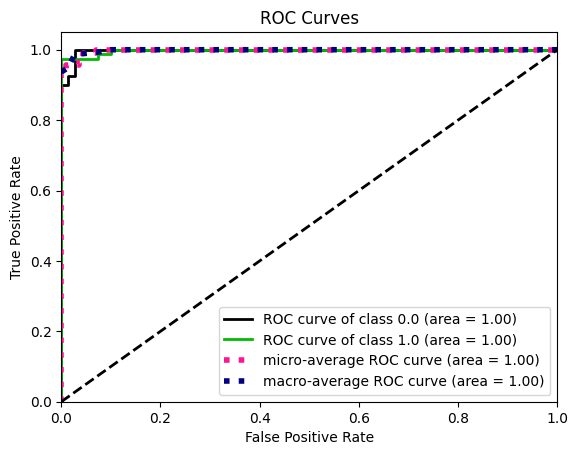

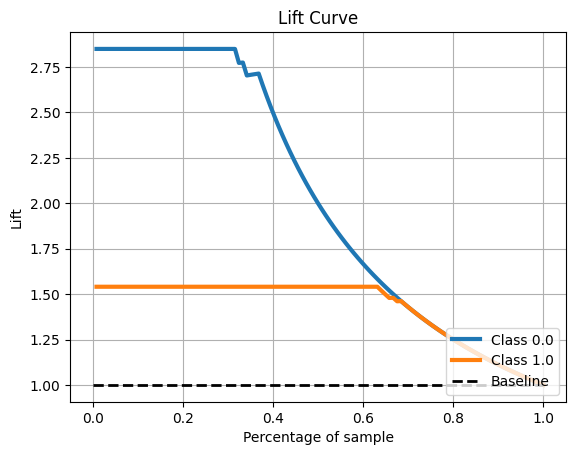

In [97]:
# AUC
fpr, tpr, threshold = roc_curve(y_test, y_pred)
auc = metrics.auc(fpr, tpr)
print("The AUC is: ", auc)
print("The kappa stats is: ", cohen_kappa_score(y_test, y_pred))
print("The MCC stats is: ", matthews_corrcoef(y_test, y_pred))

# ROC curve
predicted_probas_reg = reg_clf.predict_proba(X_test)
skplt.metrics.plot_roc(y_test, predicted_probas_reg)

# Lift curve
skplt.metrics.plot_lift_curve(y_test, predicted_probas_reg)
plt.show()

## (4) SVM

In [98]:
# Normalization
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_train_normalized = scaler.fit_transform(X_train)
X_test_normalized = scaler.transform(X_test)

In [99]:
# Tuning hyperparameters in SVM
k = ['rbf', 'linear'] # kernal
g = [0.1, 0.3, 0.5, 1] # gamma
c = [0.1, 1, 10, 100]
grid = dict(kernel = k, gamma = g, C=c)

# model 
svm = SVC(probability = True,random_state=42)

In [100]:
# non-nested parameter search and scoring
svm_clf = GridSearchCV(svm, param_grid=grid, cv = inner_cv, scoring='accuracy')

In [101]:
# fit the models
svm_clf.fit(X_train_normalized, y_train)
y_pred = svm_clf.predict(X_test_normalized)

In [102]:
# Nested CV with parameter opitimization
svm_score=cross_val_score(svm_clf,X=X,y=y, cv=outer_cv)

## Evaluate performance by cross-validation
svm_acc_scores = accuracy_score(y_test, y_pred)
svm_mtrx = confusion_matrix(y_test, y_pred)
cfr = classification_report(y_test, y_pred)

In [103]:
print('Best score:', svm_clf.best_score_)
print('Best parameters:' ,svm_clf.best_params_)
print('Best estimator: ', svm_clf.best_estimator_)
print("Mean of cross validation scores =",svm_score.mean())
print('Predictive accuracy:', svm_acc_scores)
print('\n')
print('Confusion matrix: \n', svm_mtrx)
print('\n')
print('Classification report:''\n', cfr)

Best score: 0.9736263736263737
Best parameters: {'C': 1, 'gamma': 0.1, 'kernel': 'linear'}
Best estimator:  SVC(C=1, gamma=0.1, kernel='linear', probability=True, random_state=42)
Mean of cross validation scores = 0.9595249184909175
Predictive accuracy: 1.0


Confusion matrix: 
 [[40  0]
 [ 0 74]]


Classification report:
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        40
         1.0       1.00      1.00      1.00        74

    accuracy                           1.00       114
   macro avg       1.00      1.00      1.00       114
weighted avg       1.00      1.00      1.00       114



The AUC is:  1.0
The kappa stats is:  1.0
The MCC stats is:  1.0


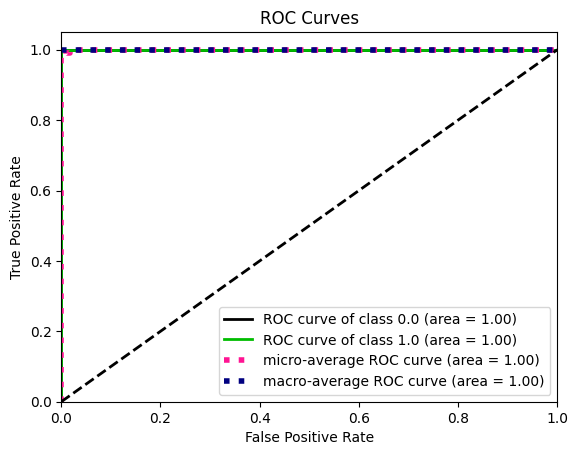

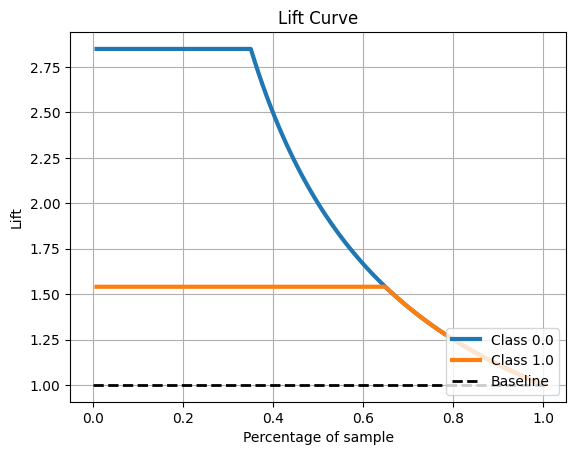

In [104]:
# AUC
fpr, tpr, threshold = roc_curve(y_test, y_pred)
auc = metrics.auc(fpr, tpr)
print("The AUC is: ", auc)
print("The kappa stats is: ", cohen_kappa_score(y_test, y_pred))
print("The MCC stats is: ", matthews_corrcoef(y_test, y_pred))

# ROC curve
predicted_probas_svm = svm_clf.predict_proba(X_test_normalized)
skplt.metrics.plot_roc(y_test, predicted_probas_svm)

# Lift curve
skplt.metrics.plot_lift_curve(y_test, predicted_probas_svm)
plt.show()

## Conclusion

Based on accuracy of the models, SVM method performs the best among four methods.The best hyperparameter is when C=1, gamma=0.1, kernel=linear. 

In [105]:
# accuracy score
model_acc = {}
model_acc['Decision Tree'] = tree_acc_scores
model_acc['KNN'] = knn_acc_scores
model_acc['Logistic Regression'] = reg_acc_scores
model_acc['SVM'] = svm_acc_scores
model_acc

{'Decision Tree': 0.956140350877193,
 'KNN': 0.9912280701754386,
 'Logistic Regression': 0.9649122807017544,
 'SVM': 1.0}